In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


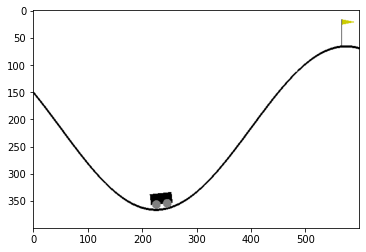

In [ ]:
#SAC for MountainCar


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
import keras.backend as k
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

class SACAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.Actor=self.build_actor_model()
    self.Critic=self.build_critic_model()
    
    self.Critic.summary()
  
  def build_actor_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Actor=Sequential()
    Actor.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(self.action_size,activation='softmax'))
    def sac_loss(y_true,y_pred):
      entropy=2e-5
      pred_reward= k.sum(y_true)
      entropy_val=k.sum(- (k.log(y_pred)))
      expectation = pred_reward + entropy_val
      prob=1e-2
      loss=-k.mean(expectation + entropy*(-(prob*k.log(prob+1e-10))))
      return loss
    Actor.compile(optimizer=Adam(learning_rate=self.learning_rate),loss=sac_loss)
    return Actor
  def build_critic_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Critic=Sequential()
    Critic.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(self.action_size,activation='softmax'))
    Critic.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Critic


  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.Critic.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards


  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.Actor.train_on_batch(x,y)
    self.Critic.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.Actor.load_weights(name)
    self.Critic.load_weights(name)
  
  def save_model(self,name):
    self.Actor.save_weights(name)
    
    self.Critic.save_weights(name)
if __name__=="__main__":
  env=gym.make('MountainCar-v0')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=SACAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      